# Importation des bibliothéques


In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
import seaborn as sns

import re
import string 


from sklearn.pipeline import Pipeline 
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.impute import SimpleImputer
import seaborn as sns

from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector

from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_absolute_error as mae

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")


# Exploration du jeu de données


In [2]:
# Lecture de df
df = pd.read_csv("titanic.csv")

# Affichage des 5 lignes
df.head(5)

# info
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Informations complémentaires sur certaines variable

| Variable | Description|
|----------|-------------|
|Survided  | 1 si survivant 0 si non |
|Pclass | Classe (1 : première, 2 : seconde, 3 : troisième)|
|SibSp | Nb frères / soeurs et / ou époux(se) à bord|
|Parch| Nb de parents et / ou enfants à bord|
|Fare| Prix du billet|
|Embarked | Part d'embarquement (C : Cherbourg, Q : Queenstown et S : Southampton)|

In [3]:
# Séparation features et target
y = df['Survived']
X = df.drop('Survived', axis=1)


# Implémentation des transformeurs

## Transformeur pour la classe des âges

Catégorisation des age de cette façon :
| Intervalle d'âge | Catégorie |
|------------------|-----------|
| 0-12 ans         | Kid       |
| 12 - 18 ans | Adolescent|
| 18 - 30 ans | Adult-|
|30 - 50 ans | Adult|
|50 - 65 ans | Adult+|
| + de 65 ans| Senior|

Création d'un trasformeur AgeCat qui retournera une colone de DF contenant les âges catégorises. 

-	Définition classe AgeCat qui hérite des classes BaseEstimator et TransformerMixim. Cette classe aura trois méthodes, __init__, fit et transform, définies de la façon suivante :
    * __init__ : le constructeur ne prend pas d’argument et ne fait rien
    * Fit : prends 2 arguments, un DataFrame X et une liste y, mais ne fait rien
    * Transform : Prend en argument un DataFrame X puis renvoie une DataFrame contenant une seule colonne correspondant à la catégorie de chaque élément de X[‘Age’]. 


In [5]:
class AgeCat(BaseEstimator, TransformerMixin):
    # BaseEstimator contient les méthodes get_params et set_params
    # TransformetMixin contient la méthode fit_transform

    def __init__(self):             # Ne fait rien
        return None
    
    def fit(self, X, y = None):     # Ne fait rien
        return self
    
    def transform(self, X):         #Création de la nouvelle colonne
        return pd.DataFrame(pd.cut(X['Age'], bins = [0, 12, 18, 30, 50, 65, np.max(df.Age)], 
                                   labels=['Kid', 'Adolescent','Adult-', 'Adult', 'Adult+', 'Senior']))

In [6]:
# Création DataFrame TestAge qui contient seulement la colonne 'Age' de X
TestAge = X[['Age']]

# Créer une instance age_categorized de AgeCat
age_categorized = AgeCat()

# Vérification que modèle retourne les âges catégorisés
age_categorized.fit_transform(TestAge)


,Age
0,Adult-
1,Adult
2,Adult-
3,Adult
4,Adult
...,...
886,Adult-
887,Adult-
888,NaN
889,Adult-


## Transformeur pour la taille de la famille

La variable SibSp et Parch, additionnées nous renseigne la taille de la famille. 

Création de la classe FamilySize qui permettra de retourner un DataFrame d'une colonne contenant la taille de la famille.

-	Définition classe FamilySize qui hérite des classes BaseEstimator et TransformerMixim. Cette classe aura trois méthodes, __init__, fit et transform, définies de la façon suivante :
    * __init__ : le constructeur ne prend pas d’argument et ne fait rien
    * Fit : prends 2 arguments, un DataFrame X et une liste y, mais ne fait rien
    * Transform : Prend en argument un DataFrame X puis renvoie une DataFrame contenant une seule colonne correspondant à la somme toutes les colonnes du DataFrame X incrémentée de 1 

In [7]:
class FamilySize(BaseEstimator, TransformerMixin):
    # BaseEstimator contient les méthodes get_params et set_params.
    # TransformerMixin contient la méthode fit_transform.
    
    def __init__(self):
        return None

        
    def fit(self, X, y = None):  # Ne fait rien. 
        return self
    
    def transform(self, X): # somme toutes les personnes de la famille + lui même 
        return pd.DataFrame(X.sum(axis=1)+1)


In [8]:
# Création DataFrame TestFamilySize qui contient ‘SibSp’ et ‘Parch’ de X. 
TestFamilySize = X[['SibSp', 'Parch']]

# Créer une instance size_family de FamilySize
size_family = FamilySize()

# Vérification que modèle retourne les taille des familles
size_family.fit_transform(TestFamilySize)

,0
0,2
1,2
2,1
3,2
4,1
...,...
886,1
887,1
888,4
889,1


## Transformeur pour la séparation de la variable 'Name'

La variable ‘Name’ possède les informations suivantes : Nom de famille, le titre ainsi que le ou les prénoms.


Ces éléments peuvent être très utiles notamment pour traiter les données manquantes d’autres variables.


Cependant, ces 3 éléments sont tous présent dans une seule et même variable ce qui rends peu exploitables. 


Création d'une classe SplitName qui permet de renvoyer ces 3 éléments dans 3 colonnes distinctes.


-	Définition classe SplitName qui hérite des classes BaseEstimator et TransformerMixim. Cette classe aura trois méthodes, __init__, fit et transform, définies de la façon suivante :
    * __init__ : Le constructeur prend 1 argument, column_name qui sera l'attribut d'une instance de SplitName. Il correspond au nom de la colonne qui devra être segmentée
    * Fit :  Prend 2 arguments, un DataFrame X et une liste y, mais ne fait rien
    * Transform  : Prend en argument un DataFrame X. Elle ajoute à ce DataFrame 3 colonnes, 'Surname', 'Title' et 'Firstname(s)' qui contiennent respectivement le nom de famille, le titre et le(s) prénom(s) présents dans la colonne 'Name'

In [11]:

def spliter(X):
    
    ''' Cette fonction auxiliaire utilise les expressions régulières afin de créer 
    une liste de 3 éléments pour chaque élément d'une colonne de DataFrame.  
    Construite pour la colonne 'Name', elle permettra de créer les listes qui auront 
    le nom, le titre et le(s) prénom(s)'''
        
    chaine=X.apply(lambda x: re.split("[.,\((.*?)\)]",x))

    for elt in chaine:
        if elt[-1]=='': # on enlève des chaines de caractères vides à la fin ''
            del(elt[-1])
    return(chaine)
    
    


In [12]:
class SplitName(BaseEstimator, TransformerMixin):
    
    def __init__(self, column_name):
        self.column_name = column_name   # nom de la colonne à segmenter
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        
        chaine=spliter(X[self.column_name]) # Retourne une liste de 3 éléments pour extraire le nom, le prénom et le titre 

        X['Surname'] = chaine.apply(lambda x : x[0] ) 
        X['Title'] = chaine.apply(lambda x : x[1][1:]) # Car il y a un espace
        X['Firstname(s)'] = chaine.apply(lambda x : x[2] )
     

        return X

In [13]:
# Création DataFrame TestName  qui contient 'PassengerId','Name','Cabin' de X. 
TestName  = X[['PassengerId','Name','Cabin']]

# Créer une instance name_split de SplitName
name_split = SplitName('Name')

# Vérification que modèle retourne le prénom, le nom et le titre
TestName = name_split.fit_transform(TestName)
TestName

,PassengerId,Name,Cabin,Surname,Title,Firstname(s)
0,1,"Braund, Mr. Owen Harris",NaN,Braund,Mr,Owen Harris
1,2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",C85,Cumings,Mrs,John Bradley
2,3,"Heikkinen, Miss. Laina",NaN,Heikkinen,Miss,Laina
3,4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",C123,Futrelle,Mrs,Jacques Heath
4,5,"Allen, Mr. William Henry",NaN,Allen,Mr,William Henry
...,...,...,...,...,...,...
886,887,"Montvila, Rev. Juozas",NaN,Montvila,Rev,Juozas
887,888,"Graham, Miss. Margaret Edith",B42,Graham,Miss,Margaret Edith
888,889,"Johnston, Miss. Catherine Helen ""Carrie""",NaN,Johnston,Miss,"Catherine Helen ""Carrie"""
889,890,"Behr, Mr. Karl Howell",C148,Behr,Mr,Karl Howell


## Transformeur pour la complétion des cabines

Détermination de % de valeurs manquantes dans la colonne 'cabin' de TestName


In [14]:
X['Cabin'].isna().sum()/len(X['Cabin'])*100

77.10437710437711

'+ de 77% de valerurs manquante, cependant cette colonne est importante car elle pourra nous servir pour situer une personne sur le paquebot. 

Pour remplacer voici la logique : les personnes qui ont le m^me nom de famille seront probablement dans une m^me cabine ou dans une cabine adjacente. 

Création d'une classe AddCabins qui permet d'ajouter les m^me cabines aux personnes ayant le même nom de famille. 



Le principe :

In [15]:
print("Pour illustrer le principe, le passager d'id 5 ne possède pas de cabines:\n\n",
      TestName.loc[TestName['PassengerId']==5][['PassengerId','Surname','Title','Cabin']], '\n\n\n',

      "Par contre si on cherche les personnes dont le nom de famille est Allen on obtient:\n\n",
      TestName.loc[TestName['Surname']=='Allen'][['PassengerId','Surname','Title','Cabin']], '\n\n',

      "On remarque que Miss Allen possède la cabine B5. \n On veut alors attribuer à Mr Allen la cabine B5 "

      )


Pour illustrer le principe, le passager d'id 5 ne possède pas de cabines:

    PassengerId Surname Title Cabin
4            5   Allen    Mr   NaN 


 Par contre si on cherche les personnes dont le nom de famille est Allen on obtient:

      PassengerId Surname Title Cabin
4              5   Allen    Mr   NaN
730          731   Allen  Miss    B5 

 On remarque que Miss Allen possède la cabine B5. 
 On veut alors attribuer à Mr Allen la cabine B5 


Création d'une liste de cabine pour chaque personne : chaque personne ayant le même nom de famille possèdera la m^me liste de cabine.


Définition ReturnCabin, qui prends en argument liste et renvoie le premier élément non null de la liste. Si la liste contient que des NaN, elle retournera un NaN.

In [16]:
def ReturnCabin(l):
    for elt in l:
        if type(elt) is str: 
            return elt 
    return np.nan

-	Définition classe AddCabin  qui hérite des classes BaseEstimator et TransformerMixim. Cette classe aura trois méthodes, __init__, fit et transform, définies de la façon suivante :
    * __init__ : Le constructeur prend 3 arguments, 'column_id' (id des individus), 'column_cabin' (cabines des passagers) et 'column_name' (noms de famille des passagers)
    * Fit :  Prend 2 arguments, un DataFrame X et une liste y. Elle stocke en mémoire dans un attribut self.Cabin_list une colonne qui possède les listes de cabines (comme dans le tableau précédent)
    * Transform  : Prend en argument un DataFrame X et applique la fonction ReturnCabin à la variable 'CabinList'

In [17]:
class AddCabins(BaseEstimator, TransformerMixin):

    def __init__(self, column_id, column_cabin, column_name):
        self.column_id = column_id 
        self.column_cabin = column_cabin #Nom de la colonne des Ids 
        self.column_name = column_name   # nom de la colonne à segmenter
        
        
    def fit(self, X, y=None):

        occurences = X[self.column_name].unique()
        self.Cabin_list = X[self.column_cabin].apply(lambda x: [])

        for family in occurences:
            liste = X.loc[X[self.column_name] == family][self.column_cabin].tolist()
            for id, name  in zip(X[self.column_id], X[self.column_name]):
                if name == family:
                    self.Cabin_list.at[id-1] = liste
        return self
    
     
    def transform(self, X):
        X.loc[:,self.column_cabin] = self.Cabin_list.apply(ReturnCabin)
        
     
        return X


In [18]:
# Création instance complete_cabins de AddCabins
complete_cabins = AddCabins('PassengerId','Cabin','Surname')

# Vérification du modèle
complete_cabins.fit_transform(TestName)
TestName.loc[TestName['PassengerId'] == 5]


,PassengerId,Name,Cabin,Surname,Title,Firstname(s)
4,5,"Allen, Mr. William Henry",B5,Allen,Mr,William Henry


Il reste  beaucoup de valeurs manquantes mais il est difficile de se passer de cette variable.

## Transformeur pour positionnement des cabines

La variable Cabin peut donner des informations très intéressantes pour le sauvetage des personnes. En effet, une personne située à coté des canots de sauvetage aura surement plus de chance de survivre qu'une personne située dans la partie inférieure du bateau.

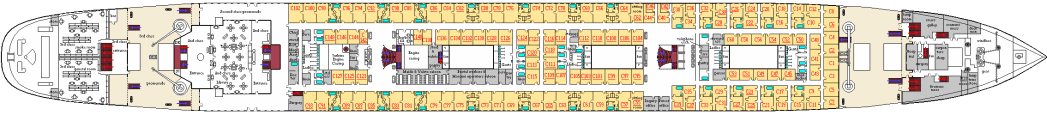

L'image ci-dessus présente le pont C, les cabines de numéro pair sont situées à bâbord (gauche en direction de la trajectoire du navire) alors que les cabines impaires sont situées à tribord (droite).

Définition un transformeur SplitCabin qui permettra de découper une chaine de caractères où le premier élément est une lettre et le reste est un entier.

-	Définition fonction babtri qui prend en argument un nombre de type float et renvoie la chaine de caractères 'Babord' si le nombre est pair, 'Tribord' si le nombre est impair et un NaN s'il n'est ni pair ni impair (En cas de valeurs manquantes).


-	Définition classe SplitCabin qui hérite des classes BaseEstimator et TransformerMixin. Cette classe aura trois méthodes, __init__, fit et transform, définies de la façon suivante:
    * __init__: Le constructeur prend 1 argument, column_name qui sera l'attribut d'une instance SplitCabin. Il correspond au nom de la colonne qui devra être segmentée.
    * fit : Prend 2 arguments, un DataFrame X et une liste y, mais ne fait rien.
    * transform : Prend en argument un DataFrame X. Elle crée un nouveau DataFrame avec deux colonnes : la colonne self.column_name+_letter qui renvoie la lettre de la cabine et la colonne self.column_name+_parite qui renvoie si la cabine est à babord ou à tribord.


In [19]:
def babtri(x):
    if x%2==0.0:
        return('Babord')
    if x%2==1.0:
        return('Tribord')
    else:
        return np.nan


class SplitCabin(BaseEstimator, TransformerMixin):
    # BaseEstimator contient les méthodes get_params et set_params.
    # TransformerMixin contient la méthode fit_transform.
    
    def __init__(self, column_name):
        self.column_name = column_name   # nom de la colonne à segmenter
        
    def fit(self, X, y = None):  # Ne fait rien. 
        return self
    
    def transform(self, X): # Création de la nouvelle colonne 
        new_X = pd.DataFrame()

        new_X[self.column_name+'_letter'] = X[self.column_name].str.slice(0,1)
        var=X[self.column_name].str.slice(1,5).str.extract("([0-9]+)").astype("float") # variable qui permet d'avoir le numéro de la cabine 
        new_X[self.column_name+"_parite"] = (var.iloc[:,0].apply(babtri))

        return new_X


In [20]:
# Création instance cabin_split de SplitCabin
cabin_split = SplitCabin('Cabin')

# Vérifiaction du modèle
cabin_split.fit_transform(TestName)

,Cabin_letter,Cabin_parite
0,NaN,NaN
1,C,Tribord
2,NaN,NaN
3,C,Tribord
4,B,Tribord
...,...,...
886,NaN,NaN
887,C,Tribord
888,NaN,NaN
889,C,Babord


## Transformeur pour la catégorisation des titres

Détermination des valeurs unique de la viriable 'Title' de TestName

In [21]:
TestName['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

Regroupement des titres dans 5 catégories:
-	Les femmes mariées ( 'Ms' et 'Miss') représentées par 'Miss'.
-	Les jeunes femmes ('Mrs') représentées par 'Mrs'.
-	Les hommes ('Rev'et 'Mr') représentés par 'Mr'.
-	Les jeunes hommes ('Master') représentés par 'Master'.
-	Les personnes qui ont des titres spéciaux: ["Dr", "Don","Mme","Major","Lady","Sir","Mlle","Col","Capt","the Countess","Jonkheer","Dona"] représentés par 'Special'.


-	Définition classe CategorizeTitle qui hérite des classes BaseEstimator et TransformerMixin. Cette classe aura trois méthodes, __init__, fit et transform, définies de la façon suivante:
    * __init__: Le constructeur prend 1 argument, column_name qui sera l'attribut d'une instance CategorizeTitle. Il correspond au nom de la colonne qui devra être catégorisée ('Title').
    * fit : Prend 2 arguments, un DataFrame X et une liste y, mais ne fait rien.
    * transform : Prend en argument un DataFrame X. Elle change les valeurs de la colonne self.column_name en les catégorisant selon 5 titres ( 'Miss', 'Mrs', 'Mr', 'Master' et 'Special').


In [22]:
class CategorizeTitle(BaseEstimator, TransformerMixin):
    # BaseEstimator contient les méthodes get_params et set_params.
    # TransformerMixin contient la méthode fit_transform.
    
    def __init__(self, column_name):
        self.column_name = column_name   # nom de la colonne à segmenter
        
    def fit(self, X, y = None):  # Ne fait rien. 
        return self
    
    def transform(self, X): # Création de la nouvelle colonne 
        

        special = ["Dr", "Don","Mme","Major","Lady","Sir","Mlle","Col","Capt","the Countess","Jonkheer","Dona"]

        X[self.column_name] = X[self.column_name].replace(special, 'Special')
        X[self.column_name] = X[self.column_name].replace(['Rev'], 'Mr')
        X[self.column_name] = X[self.column_name].replace(['Ms'], 'Miss')
        
  

        return X[[self.column_name]]


In [23]:
# Création instance cat_title de CategorizeTitle
cat_title = CategorizeTitle('Title')

# Vérification du modèle
cat_title.fit_transform(TestName)['Title'].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Special'], dtype=object)

# Création des pipelines intermédiaires

Tous les transformeurs ont été implémentés. Avec ces transformeurs et ceux déjà implémentés sous sklearn, construction du pipeline étape par étape.

## Pipeline pour les cabines


__Première étape__ : Création du pipeline qui va :
- Rempcer les valeurs manquantes de Cabin grâce au transformeur AddCabins
- Extraire le pont du numéro des cabines
- Remplacer les valeurs manquantes grâce à un SimpleImputer
- Encoder les varaibles grâce à une OneHotEncoder


In [24]:
# Création instance cabin_si de SimpleImputer
# -> Remplacement Nan par chaine de caractères missing
cabin_si = SimpleImputer(strategy='constant', fill_value="missing")

# Instance cabine_ohe de OneHotEncoder
cabin_ohe = OneHotEncoder()

In [25]:
# Création du pipeline
CabinsPipeline = Pipeline(steps=[('Complétion de cabines', complete_cabins),
                                 ('Séparation des cabines', cabin_split),
                                 ('Simple Imputer Cabines', cabin_si),
                                 ('One Hot Encoder Cabines', cabin_ohe)])

Vérification du bon focntionnement du pipeline

In [26]:
CabinsTest= X[['PassengerId','Name','Cabin']]
name_split.fit_transform(CabinsTest)
CabinsPipeline.fit_transform(CabinsTest)


<891x12 sparse matrix of type '<class 'numpy.float64'>'
	with 1782 stored elements in Compressed Sparse Row format>

## Pipeline pour les titres




__Deuxième étape__ : De même que pour les cabines, création pipeline qui va : 
- Catégoriser les titres grâce au transformeur CategorizeTitle;
- Remplacer les valeurs manquantes grâce à un SimpleImputer ;
- Encoder les variables grâce à un OneHotEncoder.

In [27]:
title_si=SimpleImputer(strategy='most_frequent')
title_ohe=OneHotEncoder()

In [28]:
TitlePipeline = Pipeline(steps=[ ('Catégorisation des titre', cat_title),
                               ('Simple Imputer Titres', title_si),
                               ('One Hot Encoder Titres', title_ohe)])


In [29]:
TitlePipeline.fit_transform(CabinsTest)


<891x5 sparse matrix of type '<class 'numpy.float64'>'
	with 891 stored elements in Compressed Sparse Row format>

## Feature Union

__Troisème étape__ : Une fois que le nom sera séparé à l'aide du transformeur SplitName, éxécution des deux pipelines précédemment implémentées. Cependant, leur exécution est indépendante l'une de l'autre.

In [30]:
# Initialisation objet FeatureUnion
FeatureUnionPipeline = FeatureUnion([("Cabin", CabinsPipeline),
                                   ("Title",TitlePipeline )])


In [31]:
FeatureTest = X[['PassengerId','Name','Cabin']]

name_split.fit_transform(FeatureTest)

FeatureUnionPipeline.fit_transform(FeatureTest)

<891x17 sparse matrix of type '<class 'numpy.float64'>'
	with 2673 stored elements in Compressed Sparse Row format>

## Regroupement des pipelines

__Quatrième étape__:Finalisation de la construction du pipeline qui effectue les opérations sur les noms. CRéation du pipeline qui effectue deux tâches :
- extraction du nom/prenom/titre grâce au SplitName
- FeatureUnion défini.

In [32]:
NamePipeline = Pipeline([('Séparation du nom', name_split),
                       ('Feature Union', FeatureUnionPipeline)])

In [33]:
Name = X[['PassengerId','Name','Cabin']]
NamePipeline.fit_transform(Name)


<891x17 sparse matrix of type '<class 'numpy.float64'>'
	with 2673 stored elements in Compressed Sparse Row format>

## Pipeline pour la taille de la famille

__Cinquième étape__ : Pour le calcul de la taille de la famille, création du pipeline qui va :
- Calculer la taille de la famille grâce au transformeur FamilySize;
- Remplacer les valeurs manquantes grâce à un SimpleImputer;
- Standardiser les données grâce à un StandardScaler.

In [34]:
size_si = SimpleImputer(strategy='mean')

size_st = StandardScaler()


In [35]:
SizeFamilyPipeline = Pipeline([('Somme famille', size_family),
                        ('Simple Imputer Size', size_si),
                        ('Standardisation Size', size_st)])




In [36]:
Sum = X[['SibSp','Parch']]

SizeFamilyPipeline.fit_transform(Sum)[:5]


array([[ 0.05915988],
       [ 0.05915988],
       [-0.56097483],
       [ 0.05915988],
       [-0.56097483]])

## Pipeline pour catégorisation des âges

__Sixième étape__ : Pour la catégorisation des âges, Création du pipeline qui va :
- Catégoriser les âge grâce au transformeur AgeCat;
- Remplacer les valeurs manquantes grâce à un SimpleImputer;
- Encoder des données grâce à un OneHotEncoder.

In [37]:
age_si = SimpleImputer(strategy='most_frequent')
age_ohe = OneHotEncoder()

In [38]:
AgePipeline = Pipeline([('Catégorisation des ages', age_categorized),
                      ('Simple Imputer Ages', age_si),
                      ('One Hot Encoder Age', age_ohe)])

In [39]:
Aget=X[['Age']]

AgePipeline.fit_transform(Aget)

<891x6 sparse matrix of type '<class 'numpy.float64'>'
	with 891 stored elements in Compressed Sparse Row format>

## Pipelines numériques et catégoriques


__Septième étape__ : D'autres variables utiles à l'analyse ont besoin de petites transformations telles que le traitement des valeurs manquantes, l'encodage ou la standardisation.


In [40]:
# Création liste num
num = ['Pclass','Fare']

# Création liste cat
cat = ['Sex','Embarked']

#Instanciation transformeur 
num_si = SimpleImputer()  
num_st = StandardScaler()
cat_si = SimpleImputer(strategy = 'most_frequent')
cat_ohe = OneHotEncoder()


# Création des pipelines
NumericalPipeline = Pipeline(steps = [('valeurs_manquantes_num',num_si),
                                    ('standardisation', num_st)])

CategorialPipeline = Pipeline(steps = [('valeurs_manquantes_cat',cat_si),
                                    ('encoder', cat_ohe)])


In [41]:
NUM = X[num]
CAT = X[cat]

print(NumericalPipeline.fit_transform(NUM)[:3], '\n\n',
CategorialPipeline.fit_transform(CAT)[:3])


[[ 0.82737724 -0.50244517]
 [-1.56610693  0.78684529]
 [ 0.82737724 -0.48885426]] 

   (0, 1)	1.0
  (0, 4)	1.0
  (1, 0)	1.0
  (1, 2)	1.0
  (2, 0)	1.0
  (2, 4)	1.0


# Preprocessing

preprocessing général du dataset grâce à la fonction make_column_transformer

In [42]:
preprocessor = make_column_transformer( (NamePipeline, ['PassengerId','Name','Cabin']),
                                     (SizeFamilyPipeline,['SibSp','Parch']),
                                     (AgePipeline, ['Age']),
                                      (NumericalPipeline, num),
                                     (CategorialPipeline, cat))

In [43]:
copie = X.copy()

preprocessor.fit_transform(copie)


<891x31 sparse matrix of type '<class 'numpy.float64'>'
	with 8019 stored elements in Compressed Sparse Row format>

# Pipeline final


Création du pipeline à deux étapes : le preprocessor défini plus haut puis un modèle de Machine Learning : GradientBoostingClassifier.

In [44]:
final_pipeline = Pipeline(steps= [('notre_p', preprocessor), 
                        ('regression_regularisee',GradientBoostingClassifier())])

# Prédiction et score

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size = 0.2, random_state = 210995)

In [46]:
from sklearn.metrics import accuracy_score

final_pipeline.fit(X_train, y_train)

y_pred = final_pipeline.predict(X_test)

accuracy_score(y_test, y_pred)


0.8156424581005587